# Advanced Visualizations — Matplotlib Only (Sage/Green Ombre Theme)

This notebook demonstrates advanced plotting patterns without seaborn, relying
exclusively on Matplotlib. It includes a custom **sage/green ombre** palette and
style helpers. Each plot is built as a standalone figure for clarity.

**Included Visuals**
1. Theme and utilities
2. Time-series with confidence interval bands
3. Correlation heatmap
4. Distribution violin plots
5. Ridge (joy) plots for grouped distributions
6. Hexbin scatter for dense relationships
7. Stacked area chart
8. Parallel coordinates (pandas.plotting)

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pandas.plotting import parallel_coordinates

# -------------------------
# Sage/Green Ombre Palette
# -------------------------
# Soft sage to deep green ombre
sage_to_green = [
    "#e8f0e6",  # very light sage
    "#cfe3cf",
    "#b5d6b9",
    "#9ccaa2",
    "#84bd8b",
    "#6bb174",
    "#54a55f",
    "#3d994a",
    "#2f7f3c",  # deeper green
]

def ombre_cmap():
    return LinearSegmentedColormap.from_list("sage_green_ombre", sage_to_green)

def apply_theme():
    plt.rcParams.update({
        "figure.figsize": (8, 5),
        "axes.facecolor": "#ffffff",
        "figure.facecolor": "#ffffff",
        "axes.edgecolor": "#333333",
        "axes.labelcolor": "#222222",
        "xtick.color": "#333333",
        "ytick.color": "#333333",
        "grid.color": "#dddddd",
        "grid.linestyle": "--",
        "grid.linewidth": 0.5,
        "font.size": 11,
        "axes.titleweight": "bold",
        "lines.linewidth": 2.0,
    })

apply_theme()
cmap = ombre_cmap()

def color_cycle(n: int):
    # Sample n colors from the ombre gradient
    xs = np.linspace(0, 1, n)
    return [cmap(x) for x in xs]

## 1) Synthetic data generator (reproducible)

In [2]:
rng = np.random.default_rng(42)

def make_timeseries(n=200, k=3):
    t = np.arange(n)
    data = {}
    for i in range(k):
        trend = 0.02 * t + rng.normal(0, 0.4, size=n)
        season = 2*np.sin(2*np.pi*t/30 + i) + rng.normal(0, 0.3, size=n)
        series = trend + season + (i*0.5)
        data[f"series_{i+1}"] = series
    df = pd.DataFrame(data); df["t"] = t
    return df

def make_clusters(n=1000):
    x = np.concatenate([rng.normal(0,1, n//2), rng.normal(3,1.2, n//2)])
    y = np.concatenate([rng.normal(0,1, n//2), rng.normal(3,1.0, n//2)])
    return pd.DataFrame({"x": x, "y": y})

def make_grouped_dists(groups=6, n=300):
    rows = []
    for g in range(groups):
        mu = g * 0.75
        s = 0.4 + 0.1*g
        vals = rng.normal(mu, s, size=n)
        rows.extend([(f"G{g+1}", v) for v in vals])
    return pd.DataFrame(rows, columns=["group", "value"])

## 2) Time-series with confidence bands

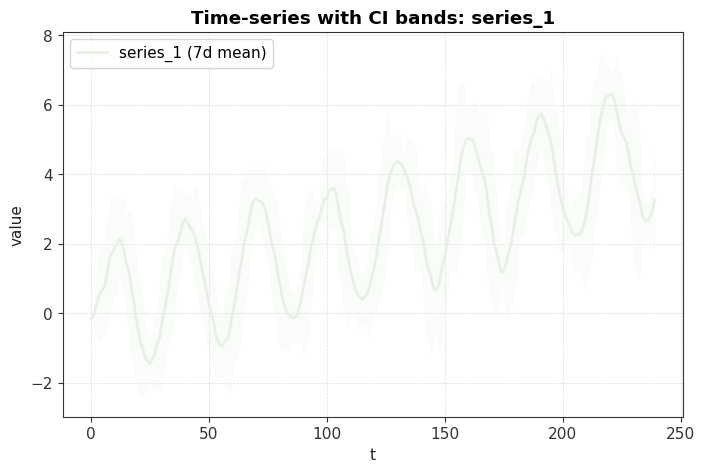

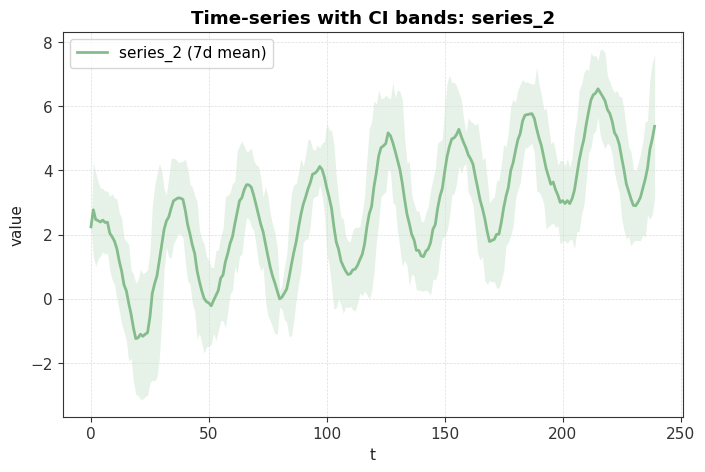

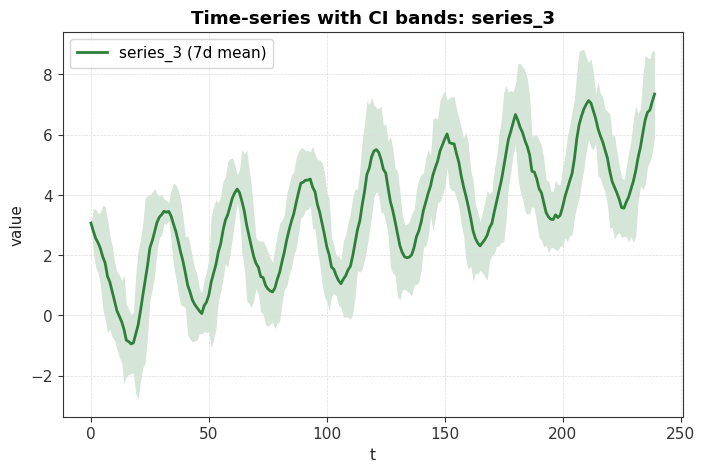

In [3]:
df_ts = make_timeseries(n=240, k=3)
cols = [c for c in df_ts.columns if c.startswith("series_")]
t = df_ts["t"].values
palette = color_cycle(len(cols))

for idx, col in enumerate(cols):
    y = df_ts[col].values
    y_hat = pd.Series(y).rolling(7, min_periods=1).mean().values
    # naive CI band from rolling std (for demo)
    s = pd.Series(y).rolling(7, min_periods=1).std().fillna(0.0).values
    lo, hi = y_hat - 1.96*s, y_hat + 1.96*s

    fig, ax = plt.subplots()
    ax.plot(t, y_hat, color=palette[idx], label=f"{col} (7d mean)")
    ax.fill_between(t, lo, hi, color=palette[idx], alpha=0.2, linewidth=0)
    ax.set_title(f"Time-series with CI bands: {col}")
    ax.set_xlabel("t"); ax.set_ylabel("value"); ax.grid(True)
    ax.legend(loc="upper left")
    plt.show()

## 3) Correlation heatmap

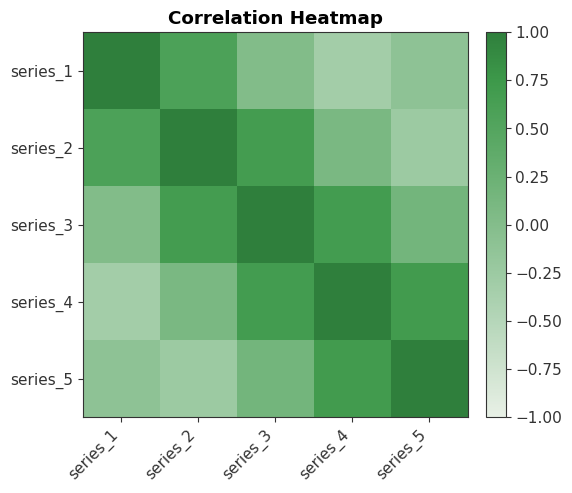

In [4]:
# Build a wide matrix with correlations
wide = make_timeseries(n=180, k=5).drop(columns=["t"])
corr = wide.corr()

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, cmap=cmap, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index))); ax.set_yticklabels(corr.index)
ax.set_title("Correlation Heatmap")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.grid(False)
plt.show()

## 4) Violin plots (distribution comparison)

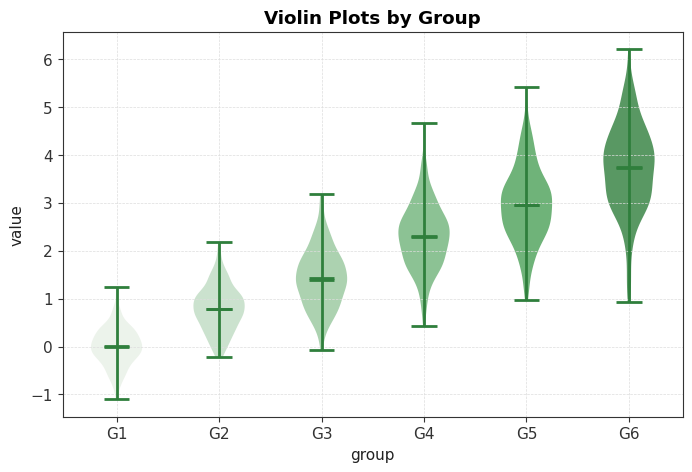

In [5]:
df_grp = make_grouped_dists(groups=6, n=250)
groups = sorted(df_grp["group"].unique())
data = [df_grp[df_grp["group"]==g]["value"].values for g in groups]

fig, ax = plt.subplots()
parts = ax.violinplot(data, showmeans=True, showextrema=True, showmedians=True)
# style each body with ombre progression
for i, b in enumerate(parts['bodies']):
    b.set_facecolor(color_cycle(len(groups))[i])
    b.set_alpha(0.8)
for comp in ("cbars","cmins","cmaxes","cmeans","cmedians"):
    if comp in parts: parts[comp].set_color("#2f7f3c")
ax.set_xticks(np.arange(1, len(groups)+1)); ax.set_xticklabels(groups)
ax.set_title("Violin Plots by Group"); ax.set_xlabel("group"); ax.set_ylabel("value")
ax.grid(True)
plt.show()

## 5) Ridge (joy) plots for grouped distributions

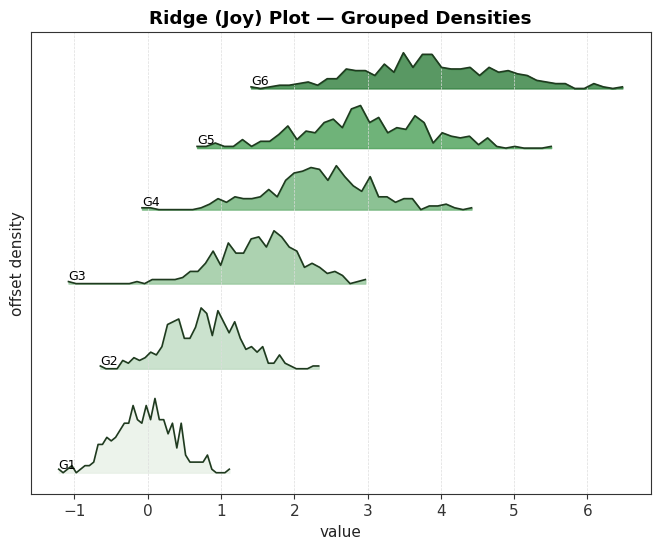

In [6]:
# Build ridge plots by layering offset distributions
df_grp2 = make_grouped_dists(groups=6, n=300)
groups = sorted(df_grp2["group"].unique())
palette = color_cycle(len(groups))

fig, ax = plt.subplots(figsize=(8,6))
offset = 0
for i, g in enumerate(groups):
    vals = df_grp2[df_grp2["group"]==g]["value"].values
    # histogram density
    counts, bins = np.histogram(vals, bins=40, density=True)
    centers = 0.5*(bins[1:]+bins[:-1])
    y = counts + offset
    ax.fill_between(centers, offset, y, color=palette[i], alpha=0.8)
    ax.plot(centers, y, color="#1f3a1f", linewidth=1.2)
    ax.text(centers.min(), offset+0.02, g, va="bottom", ha="left", fontsize=9)
    offset += counts.max() * 1.4  # vertical spacing

ax.set_title("Ridge (Joy) Plot — Grouped Densities")
ax.set_xlabel("value"); ax.set_ylabel("offset density")
ax.grid(True, axis="x")
ax.set_yticks([])
plt.show()

## 6) Hexbin scatter for dense relationships

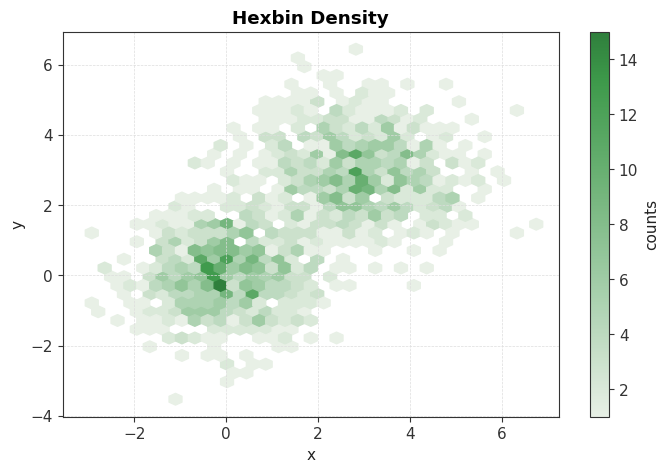

In [7]:
df_xy = make_clusters(1500)

fig, ax = plt.subplots()
hb = ax.hexbin(df_xy["x"], df_xy["y"], gridsize=35, cmap=cmap, mincnt=1)
ax.set_title("Hexbin Density")
ax.set_xlabel("x"); ax.set_ylabel("y")
cb = fig.colorbar(hb, ax=ax)
cb.set_label("counts")
ax.grid(True)
plt.show()

## 7) Stacked area chart

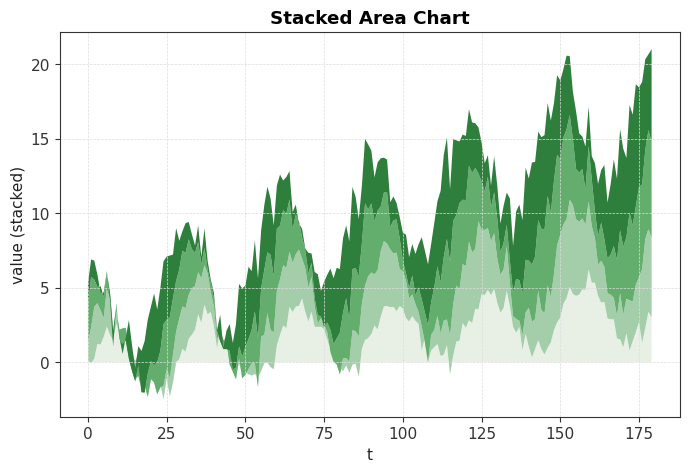

In [8]:
df_area = make_timeseries(n=180, k=4)
t = df_area["t"].values
ys = np.vstack([df_area[c].values for c in df_area.columns if c.startswith("series_")])
cols = color_cycle(ys.shape[0])

fig, ax = plt.subplots()
ax.stackplot(t, ys, colors=cols, baseline="zero")
ax.set_title("Stacked Area Chart")
ax.set_xlabel("t"); ax.set_ylabel("value (stacked)")
ax.grid(True)
plt.show()

## 8) Parallel coordinates

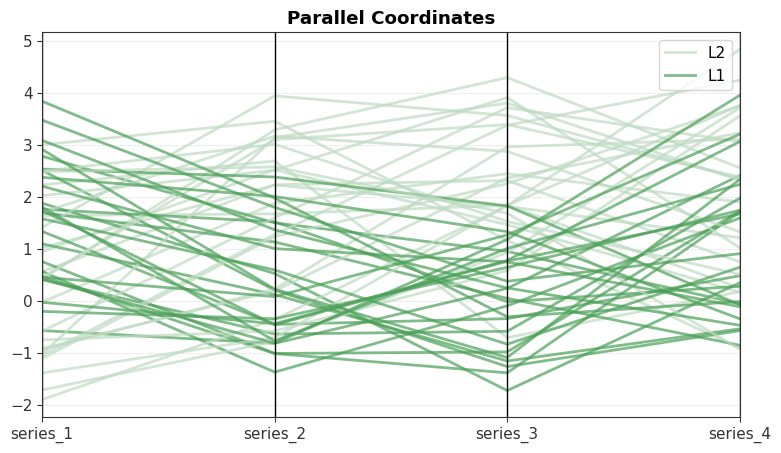

In [9]:
# Use a small labeled dataset
df_pc = make_timeseries(n=50, k=4).drop(columns=["t"]).copy()
df_pc["label"] = np.where(df_pc["series_1"]>df_pc["series_2"], "L1", "L2")

fig, ax = plt.subplots(figsize=(9,5))
# pandas parallel_coordinates relies on matplotlib under the hood
parallel_coordinates(df_pc, "label", color=[cmap(0.2), cmap(0.8)], alpha=0.7, ax=ax)
ax.set_title("Parallel Coordinates")
ax.grid(True)
plt.show()

### Notes

- All visuals use Matplotlib without seaborn, as requested.
- The custom palette is a soft sage-to-green ombre. You can adapt `sage_to_green` to match branding.
- Each figure is standalone for copy/paste into reports.
- If you experience font issues on some systems, set `plt.rcParams["font.sans-serif"] = ["DejaVu Sans", "Arial"]` before plotting.